# King County Housing Price Prediction

## Overview
This project will utilize multiple regression analysis to predict housing prices in King County, WA. The training data will be explored for feature building and the final model will be built and trained by SciKit python library. The data and project scope was provide by Flatiron School for Data Science Immersive program phase 2 final project. 

## Business Problem
A Seattle real estate company seeks to increase porfolio in King County, WA and wants to accurately predict the sales price of a property. Having an accurate sales prediction will aid in strategizing the investment options to maximize their profit. A multiple linaer regression model will be built base on provided property data for this task. 

During the exploratory phase following questions will also be focused on:
1. What location in the county has the highest property value?
2. What aspects of the property brings value?
3. Do renovations have effect on property value?

## Approach

First, the data was checked for integrity and stastistical tests such as ANOVA and Welch's T-test were performed to find significance within the data. It was found that the zipcode of the property, renotavtion status, presence of basement, and condition of the properties were found to be a significant factor of the property value. 

Second, many features were engineered to enhance the linear regression modeling. Some features were re-created as bernoulli distribution to be used as categorical data, for example presence of master bathroom. Ordinal values such as bedroom and bathrooms were also squared to accentuate the effect of multiple bathrooms and bedrooms on property prices. 

Last, four linear regression models were created with statsmodel OLS method set as the baseline. This model was heavily based on engineered features. Then, three models were created from Scikit-Learn libraries: basic linear regression, linear regression with recursive feature eliminiation, and linear regression with recursive feature elimination and cross validation. Upon the coefficient analysis it was determined that the linear regression with recursive feature eliminiation model was most stable model and it was chosen for the final implementation. 

## Implementation
Implementation of feature engineering and the final model for the test data set can be found in `king_county_prediction.ipynb`

<h2 align="center">Library and Data Import</h2>

In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn import metrics
import pickle
%matplotlib inline
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [2]:
kc_df = pd.read_csv("data/kc_house_data_train.csv", index_col=0)

***

<h2 align="center">Exploratory Data Analysis</h2>

This section will seek to answer the questions listed in business problems. The data will be visualized for easy understanding and followed with appropriate statistical analysis for empirical findings within data. Following are the summaries of the questions answered in this section:

1. What neighborhood contains most valuable properties?
2. Does condition of the property affect the value?
    - Are the property age and condition related?
3. What features add value to the house?
    - Do renovations increase property value?
    - Do basements increase property value?

### Data Integrity and Description

First, the data will be checked for completeness and integrity. This will also provide an opportunity to quickly overview the data set and prepare the future steps. 

In [3]:
total_null = 0 
for null_count in kc_df.isnull().sum():
    total_null += null_count
print(f"There are total {total_null} null values in the data")

There are total 0 null values in the data


The data is free of null values and will not require further data cleaning. 

### Data Structure
The data set contains mix of continuous and categorical values. They are separated by columns and below is a brief summary of each columns. Further details can be found in King County [website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r). 



#### Column Description
- **id** - unique ID for a house
- **date** - Date day house was sold
- **price** - Price is prediction target
- **bedrooms** - Number of bedrooms
- **bathrooms** - Number of bathrooms
- **sqft_living** - square footage of the home
- **sqft_lot** - square footage of the lot
- **floors** - Total floors (levels) in house
- **waterfront** - Whether house has a view to a waterfront
- **view** - Number of times house has been viewed
- **condition** - How good the condition is (overall)
- **grade** - overall grade given to the housing unit, based on King County grading system
- **sqft_above** - square footage of house (apart from basement)
- **sqft_basement** - square footage of the basement
- **yr_built** - Year when house was built
- **yr_renovated** - Year when house was renovated
- **zipcode** - zip code in which house is located
- **lat** - Latitude coordinate
- **long** - Longitude coordinate
- **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
- **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

Given that many columns contain categorical values that are not pertinent to basic statistical analysis, only few will be chosen for brief overlook of the data.

In [4]:
summary_features = ["price", "yr_built", "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
                    "floors", "condition", "grade", "sqft_living15", "sqft_lot15"]

In [5]:
kc_df[summary_features].describe()

,price,yr_built,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_living15,sqft_lot15
count,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,5.407395e+05,1970.792019,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,3.408502,7.654425,1987.986698,12873.475824
std,3.733190e+05,29.343516,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.651296,1.174718,684.802635,27227.437583
min,7.500000e+04,1900.000000,0.000000,0.000000,290.000000,5.720000e+02,1.000000,1.000000,1.000000,399.000000,659.000000
25%,3.210000e+05,1951.000000,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,3.000000,7.000000,1490.000000,5111.250000
50%,4.500000e+05,1974.000000,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,3.000000,7.000000,1840.000000,7622.500000
75%,6.450000e+05,1996.000000,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,4.000000,8.000000,2360.000000,10101.750000
max,7.700000e+06,2015.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,6210.000000,858132.000000


#### Column Analysis (summary_features)
- **price** - Price has a large gap of 2 magnitude. Further analysis will be required especially against the sale date. 
- **yr_built** - The data set contains builds built from 1900 to 2015.
- **bedrooms** - 0 bedrooms indicate studio apartment, most homes contain 4 or less bedrooms with some extreme outliers.
- **bathrooms** - Surprising to find that there are homes with 0 bathrooms. Most seem to have at least a 3/4 bathroom. 
- **sqft_living** - Living area also varies greatly from a small apartments to mansions. 
- **sqft_lot** - Similar to sqft_living above.
- **floors** - There are half floors to account for, which are top levels that do not spand the entirity of the house. 
- **condition** - Average properties sold are sold at 3.4 (may require superficial repair).
- **grade** - Average grade given in King County is 7, which means average properties are sold in slightly above average grade. 
- **sqft_living15** - The neighboring properties tend to be similar in sizes (similar trend to sqft_lving)
- **sqft_lot15** - Similar to sqft_living15 above

### Property Value by Zipcode

#### What neighborhood contains most valuable properties?
<br>
Analyzing the average property values per zipcode results in Medina, Belleve, Mercer Island, Madison Park, and Capitol Hill area to be neighborhood with the highest average property values. Most properties in these neighborhood doubles the average property value of King County with average property value of Medina **quadrupling** that of King County. It seems that the proximity to the Lake Washington and large parks are driving the value of these properties higher. 

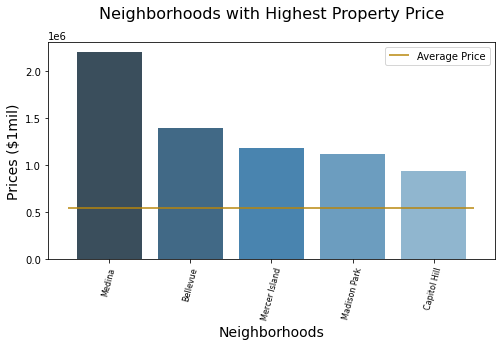

In [6]:
#property values by zipcode calculation
kc_top5_price = kc_df.groupby("zipcode")["price"].mean().sort_values(ascending = False)[:5]
kc_mean_price = kc_df.price.mean()
#top5 neighborhood label for plot
area_labels = ["Medina", "Bellevue", "Mercer Island", 
               "Madison Park", "Capitol Hill"]

#plotting the data
plt.subplots(figsize=(8,4))
sns.barplot(x=kc_top5_price.index, y=kc_top5_price, order=kc_top5_price.index, palette="Blues_d") #blue for seahawks!
plt.xticks(np.arange(5), area_labels, rotation=75, size=8) #relabel x with list above
plt.hlines(kc_mean_price, -.5 ,4.5, colors="darkgoldenrod", label="Average Price") #plot average price horizontal line

#prettify graph
plt.xlabel("Neighborhoods", size=14)
plt.ylabel("Prices ($1mil)", size=14)
plt.title("Neighborhoods with Highest Property Price", size=16, y=1.08)
plt.legend() #show legend

#uncomment line below to export image
# plt.savefig("images/high_price_neighborhood.png",bbox_inches = "tight")
plt.show();

In [7]:
#shapefile data setup
king_county = gpd.read_file("data/zipcode_shape/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shp")
king_county["zipcode"] = king_county["ZIP"] #set up column for merge

#kc_df price setup
zip_price = kc_df.groupby("zipcode").price.mean()

#plotting data setup
zip_plot_df = king_county.join(zip_price, on="zipcode", how="inner")

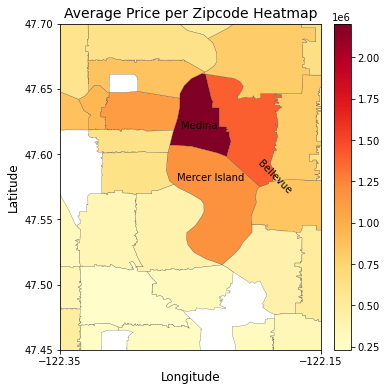

In [8]:
#plot setup
fig, ax = plt.subplots(figsize=(12,6))
zip_plot_df.plot(column="price", cmap="YlOrRd", linewidth=.25, edgecolor=".25", ax=ax)

#set up colorbar
color_bar = plt.cm.ScalarMappable(cmap="YlOrRd", norm=plt.Normalize(vmin=zip_price.min(), vmax=zip_price.max()))
color_bar._A = []
cbar = fig.colorbar(color_bar, fraction=0.03, pad=0.02)

#set figure limit to zoom in on select neighborhoods
ax.set_ylim(47.45, 47.7)
ax.set_xlim(-122.35, -122.15)
ax.set_xticks([-122.35, -122.15])
ax.set_ylabel("Latitude", size=12)
ax.set_xlabel("Longitude", size=12)

#labeling few areas
ax.text(-122.257, 47.62, 'Medina')
ax.text(-122.2, 47.57, 'Bellevue', rotation=-45)
ax.text(-122.26, 47.58, 'Mercer Island')

plt.title("Average Price per Zipcode Heatmap", size=14)
#uncomment below to save image
# plt.savefig("images/zipcode_price_heatmap.png",bbox_inches = "tight")
plt.show();

#### ANOVA of Property Prices using Top 5 Neighborhoods

In [10]:
alpha = 0.05 
#ANOVA Test Setup
kc_top5 = kc_df[kc_df.zipcode.isin(kc_top5_price.index)]
formula = 'price~C(zipcode)'
lm_top5 = smf.ols(formula, kc_top5).fit()
anova_top5_table = sm.stats.anova_lm(lm_top5, typ=2)

if anova_top5_table["PR(>F)"][0] < alpha:
    print("Top 5 ranked zipcode have a statistically significant impact on average property value")
    print("Zipcdoe ANOVA F-statisic Probability: ", anova_top5_table["PR(>F)"][0])

Top 5 ranked zipcode have a statistically significant impact on average property value
Zipcdoe ANOVA F-statisic Probability:  1.2515560223110402e-19


Findings above

### Property Value per Condition
#### Does Condition Affect Property Value?

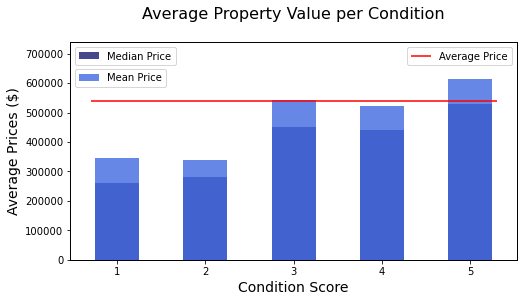

In [11]:
#-------------------Conditions Calculation--------------------------------#
condition_mean = kc_df.groupby("condition")["price"].mean()
condition_median = kc_df.groupby("condition")["price"].median()
condition_score = np.arange(1,6)

#--------------------------Bar Plots--------------------------------------#
#set subplot data
fig, ax = plt.subplots(figsize=(8,4))
ax2 = ax.twinx() #set ax2 on same x axis as ax
ax3 = ax.twinx() #same as above, for hline
width = 0.5

#barplots 
ax.bar(x=condition_score, height=condition_median, width=width,
       label="Median Price", color="midnightblue", alpha=0.8)
ax2.bar(x=condition_score, height=condition_mean, width=width,
        label="Mean Price", color="royalblue", alpha=0.8)

#horizontal line for mean price
ax3.hlines(kc_mean_price, .7 ,5.3, colors="red", label="Average Price")

#set ylimit to the same scale and display only 1
ax.set_ylim(0,1.2*condition_mean.max())
ax2.set_ylim(0,1.2*condition_mean.max())
ax3.set_ylim(0,1.2*condition_mean.max())
ax2.yaxis.set_visible(False) #hide the 2nd axis
ax3.yaxis.set_visible(False)

#set legend positions
ax.legend(bbox_to_anchor=(0,0,1,1), loc="upper left")
ax2.legend(bbox_to_anchor=(0,-.1,1,1), loc="upper left")
ax3.legend(bbox_to_anchor=(0,0,1,1), loc="upper right")

#prettify graph
ax.set_ylabel("Average Prices ($)", size=14)
ax.set_xlabel("Condition Score", size=14)
plt.title("Average Property Value per Condition", size=16, y=1.08)

#uncomment line below to export image
# plt.savefig("images/condition_value.png",bbox_inches = "tight")
plt.legend()
plt.show();

#### ANOVA of Property Prices using Conditions

In [12]:
alpha = 0.05 
#ANOVA Test Setup
formula = 'price~C(condition)'
lm_condition = smf.ols(formula, kc_df).fit()
anova_condition = sm.stats.anova_lm(lm_condition, typ=2)

if anova_condition["PR(>F)"][0] < alpha:
    print("The property condition have a statistically significant impact on average property value")
    print("Conditions F-statisic Probability: ", anova_condition["PR(>F)"][0])

The property condition have a statistically significant impact on average property value
Conditions F-statisic Probability:  6.813536869407728e-24


Property Conditions Statistical Analysis
𝛼  = 0.05

Null-Hypothesis: There are no significant difference in average property value between different conditions.
<br>
Alternative Hypothesis: There no significant difference in average property value between different conditions.


Property condition have significant affect on the value of the property. Both mean and median property prices are in upward trends as the condition increases. However, a slight dip in both aspects can be found on condition 4/5 compared to 3/5. This is most likely due to apartments/coop, which may have maintenance separete from the property itself. Therefore, the property value could be lower, due to smaller size, but have higher condition. 

### Features and Upgrades of Property

#### Does a house having a basement add value to the property?
#### Does a renovation add value to the property?

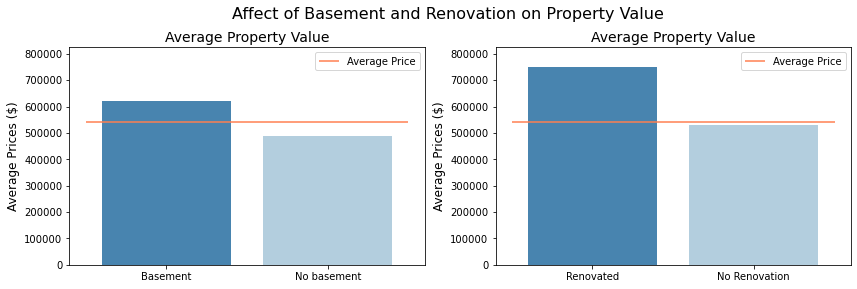

In [13]:
#--------------------------Property Feature Calculation---------------------------------------#
basement = kc_df[(kc_df["sqft_basement"] > 0)]
basement_mean = basement.price.mean()
no_basement = kc_df[(kc_df["sqft_basement"] == 0)]
no_basement_mean = no_basement.price.mean()

#mean values to plot
renovated = kc_df[(kc_df["yr_renovated"] > 0)]
renovated_mean = renovated.price.mean()
not_renovated = kc_df[(kc_df["yr_renovated"] == 0)]
not_renovated_mean = not_renovated.price.mean()

#prepare plot labels
label_basement = ["Basement", "No basement"]
values_basement = [basement_mean, no_basement_mean]
label_renovation = ["Renovated", "No Renovation"]
values_renovation = [renovated_mean, not_renovated_mean]

#--------------------------Bar Plots--------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(14,4))

sns.barplot(ax=ax[0], x=label_basement, y=values_basement, palette="Blues_r")
sns.barplot(ax=ax[1], x=label_renovation, y=values_renovation, palette="Blues_r")
ax[0].hlines(kc_mean_price, -.5 ,1.5, colors="coral", label="Average Price") #plot average price horizontal line
ax[1].hlines(kc_mean_price, -.5 ,1.5, colors="coral", label="Average Price") #plot average price horizontal line

#prettify graph
ax[0].set_ylabel("Average Prices ($)", size=12)
ax[0].set_title("Average Property Value", size=14)
ax[0].set_ylim(0,1.1*renovated_mean)
ax[0].legend()

ax[1].set_ylabel("Average Prices ($)", size=12)
ax[1].set_title("Average Property Value", size=14)
ax[1].set_ylim(0,1.1*renovated_mean)
ax[1].legend()

plt.suptitle("Affect of Basement and Renovation on Property Value", size=16, y=1.02)

#uncomment below to export image
# plt.savefig("images/basement_renovation_value.png",bbox_inches = "tight")
plt.show();

In [14]:
alpha = 0.05
basement_p_val = stats.ttest_ind(basement.price, no_basement.price, equal_var=False)[1]
print("Basement vs No Basement T-test P Value: ", basement_p_val)
if basement_p_val < alpha:
    print("The P value is less than alpha, reject null-hypothesis")

print("\n") #white space for formatting output

renovation_p_val = stats.ttest_ind(renovated.price, not_renovated.price, equal_var=False)[1]
print("Renovated vs Not Renovated T-test P Value: ", renovation_p_val)
if renovation_p_val < alpha:
    print("The P value is less than alpha, reject null-hypothesis")

Basement vs No Basement T-test P Value:  1.935598808013724e-102
The P value is less than alpha, reject null-hypothesis


Renovated vs Not Renovated T-test P Value:  6.478917377975333e-20
The P value is less than alpha, reject null-hypothesis


#### Property Features Statistical Analysis

$\alpha$ = 0.05

**Basement** <Br>
Null-Hypothesis: There are no significant difference in average property value between properties with or without basements. <Br>
Alternative Hypothesis: There no significant difference in average property value between properties with or without basements. 
<Br>
    
**Renovation** <Br>
Null-Hypothesis: There are no significant difference in average property value between properties with or without renovation. 
<Br>
Alternative Hypothesis: There no significant difference in average property value between properties with or without renovation. 
    

Both basement and renovation add significant value to the property, with renovation having larger average impact on the property value. 

### EDA Summary

1. What neighborhood contains most valuable properties?
    - Medina, Belleve, Mercer Island, Madison Park, and Capitol Hill neighborhood in King County have highest average property values. The property values of these areas have statistically significant differences from the King County average property values. 
    

2. Does condition of the property affect the value?
    - Conditions of the property have statistically significant effects on the property value. However, the average value of condition 4/5 was less than the condition of 3/5. This could be due to other factors such as apartments/co-ops, which may have lower price per property, but tends to be better maintained than a private home. 


3. What features add value to the house?
    - A renovated property have higher value than a non-renovated property.
    - Basements add significant value to the property.

***

<h2 align="center">Feature Engineering</h2>

### Renovation

Since renovation has significant impact on the property value this feature can be updated to a categorical feature

In [15]:
kc_df["renovated"] = kc_df.yr_renovated.apply(lambda x: 1 if x > 0 else 0)

### Renovation Age
Renovation value may depreciate with age, so this feature may provide a negatively correlated feature

In [16]:
kc_df["renovation_age"] = kc_df.yr_renovated.apply(lambda x: 2020-x if x > 0 else 0)

### Basement
The idea of this feature is similar to the renovation. Since having a basement automatically add values to the property, it could guide the model better as a binary categorical feature.

In [17]:
kc_df["basement"] = kc_df.sqft_basement.apply(lambda x: 1 if x != 0 else 0)

### Master Bathroom

Properties with 2 or more bathrooms are most likely to contain a master bathroom, which is highly desirable to many buyers. It is not a gaurantee that a property with 2 bathrooms have a master bathroom. However, given that bathroom is a highly correlated column to prices and contain multiple colinearity between other features it could be a good candidate for feature engineering.

In [18]:
kc_df["master_bathroom"] = kc_df.bathrooms.apply(lambda x: 1 if x > 2 else 0)

### Family House
Similar idea to master bathroom above this feature was created to guide the model to separate properties from apartments to houses. This is not a perfect implementation, but a simple way to separate small apartments like a studio. 

In [19]:
kc_df["family_house"] = kc_df.bedrooms.apply(lambda x: 1 if x > 2 else 0)

### Sold Year and Sold Quarter

The date column is in strings. To process them as integers they were divided into the year and quarters of the year.

In [20]:
kc_df["sale_year"] = kc_df.date.apply(lambda x: int(x[:4])) #convert first 4 character, year, into int
kc_df["sale_quarter"] = kc_df.date.apply(lambda x: int(x[4:6])//3.1 + 1) #fancy math convert month, 4-5 index, to quarters in int

### Zipcode Dummy Variables

Since zipcodes are not an ordinal value they would serve better as "dummy values"

In [21]:
ziplist = pd.Series(kc_df["zipcode"]) #make dummy columns
kc_df = kc_df.merge(pd.get_dummies(ziplist), left_index=True, right_index=True) #merge dummy columns

### Squared Bedrooms and Bathrooms
Since these are highly correlated with price, their impact could be increased by squaring their values. This will reduce the impact that 0 and 1 have on the linear model. 

In [22]:
kc_df["bedroom_squared"] = kc_df["bedrooms"] ** 2
kc_df["bathroom_squared"] = kc_df["bathrooms"] ** 2

#### Feature Check
All features should be float or integer before going to engineering. Date, id, and price column will be eliminated before being added to Sklearn linear regression training. 

In [23]:
# uncomment to check the data set
kc_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,renovation_age,basement,master_bathroom,family_house,sale_year,sale_quarter,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199,bedroom_squared,bathroom_squared
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,0,0,0,1,1,2014,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,5.0625
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,0,0,1,1,1,2014,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,9.0000
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,0,0,0,1,1,2014,3.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,6.2500
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,0,0,0,1,1,2015,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,12.2500
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,0,0,0,1,1,2014,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,6.2500


***

<h2 align="center">Linear Regression</h2>

### Training and Test Data Setup

In [24]:
features = [col for col in kc_df.columns if col not in ["id", "date", "price"] ] #remove id, date, and price column from features
lr_kc_df = kc_df[features] #set train/test data using feature above
model_target = kc_df["price"] #target column is the price column

In [25]:
x_train, x_test, y_train, y_test = train_test_split(lr_kc_df, model_target ,test_size=0.2)

### Preliminary Mulitple Linear Regression
This model will serve as the baseline comparison for all other models. This model is for utilizing some basic features and engineered features. The adjusted R-squared value of this model is 0.738

In [26]:
eq = "price~sqft_living+C(zipcode)+condition+renovation_age+sale_year+C(sale_quarter)+C(basement)+bedroom_squared+bathroom_squared"
kc_ols = smf.ols(formula=eq, data=kc_df).fit()
# uncomment below for summary of the ols model
# print(kc_ols.summary())
ols_result = kc_ols.predict(x_train)
ols_rmse = np.sqrt(metrics.mean_squared_error(y_train, ols_result))

In [27]:
kc_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     618.4
Date:                Fri, 23 Oct 2020   Prob (F-statistic):               0.00
Time:                        01:00:18   Log-Likelihood:            -2.3474e+05
No. Observations:               17290   AIC:                         4.696e+05
Df Residuals:                   17210   BIC:                         4.703e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -8.908e+07   1.06e+07     -8.428      0.000    -1.1e+08   -6.84e+07
C(zipcode)[T.98002]     1614.0286    1.9e+04      0.085      0.932   -3.57e+04    3.89e+04
C(zipcode)[T.98003]     1236.5023   1.71e+04      0.072      0.942   -3.22e+04    3.47e+04
C(zipcode)[T.98004]     8.352e+05   1.69e+04     49.370      0.000    8.02e+05    8.68e+05
C(zipcode)[T.98005]      3.28e+05   1.98e+04     16.569      0.000    2.89e+05    3.67e+05
C(zipcode)[T.98006]     3.162e+05   1.51e+04     20.988      0.000    2.87e+05    3.46e+05
C(zipcode)[T.98007]      2.66e+05   2.07e+04     12.855      0.000    2.25e+05    3.07e+05
C(zipcode)[T.98008]     3.051e+05   1.71e+04     17.885      0.000    2.72e+05    3.39e+05
C(zipcode)[T.98010]     5.977e+04   2.49e+04      2.396      0.017    1.09e+04    1.09e+05
C(zipcode)[T.98011]     1.279e+05   1.88e+04      6.807      0.000     9.1e+04    1.65e+05
C(zipcode)[T.98014]     1.156e+05   2.21e+04      5.219      0.000    7.22e+04    1.59e+05
C(zipcode)[T.98019]     6.454e+04   1.95e+04      3.307      0.001    2.63e+04    1.03e+05
C(zipcode)[T.98022]     2.749e+04    1.8e+04      1.530      0.126   -7718.986    6.27e+04
C(zipcode)[T.98023]    -1.239e+04   1.48e+04     -0.840      0.401   -4.13e+04    1.65e+04
C(zipcode)[T.98024]     1.738e+05   2.63e+04      6.615      0.000    1.22e+05    2.25e+05
C(zipcode)[T.98027]     1.752e+05   1.55e+04     11.314      0.000    1.45e+05    2.06e+05
C(zipcode)[T.98028]     1.319e+05   1.72e+04      7.675      0.000    9.82e+04    1.66e+05
C(zipcode)[T.98029]     2.128e+05   1.66e+04     12.807      0.000     1.8e+05    2.45e+05
C(zipcode)[T.98030]    -8318.1831   1.76e+04     -0.472      0.637   -4.28e+04    2.62e+04
C(zipcode)[T.98031]     -788.2888   1.73e+04     -0.046      0.964   -3.47e+04    3.31e+04
C(zipcode)[T.98032]     2.683e+04    2.2e+04      1.220      0.222   -1.63e+04    6.99e+04
C(zipcode)[T.98033]     3.867e+05   1.52e+04     25.378      0.000    3.57e+05    4.17e+05
C(zipcode)[T.98034]     2.291e+05   1.46e+04     15.714      0.000    2.01e+05    2.58e+05
C(zipcode)[T.98038]     4997.2539   1.45e+04      0.345      0.730   -2.34e+04    3.34e+04
C(zipcode)[T.98039]     1.368e+06   3.18e+04     43.009      0.000    1.31e+06    1.43e+06
C(zipcode)[T.98040]     5.853e+05   1.71e+04     34.161      0.000    5.52e+05    6.19e+05
C(zipcode)[T.98042]    -4297.8960   1.47e+04     -0.293      0.770    -3.3e+04    2.45e+04
C(zipcode)[T.98045]     1.142e+05   1.83e+04      6.228      0.000    7.82e+04     1.5e+05
C(zipcode)[T.98052]     2.438e+05   1.44e+04     16.977      0.000    2.16e+05    2.72e+05
C(zipcode)[T.98053]      1.98e+05   1.56e+04     12.675      0.000    1.67e+05    2.29e+05
C(zipcode)[T.98055]     4.647e+04   1.74e+04      2.673      0.008    1.24e+04  

### Scikit Learn Linear Regression

First a model will be created using basic linear regression model from Scikit-learn library. This model will test all features within the dataset and be used for comparison for future feature selection methods. 

In [28]:
#fit model
lm_kc = LinearRegression().fit(x_train, y_train)

#training data prediction
y_train_prediction = lm_kc.predict(x_test)

#rmse
train_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_train_prediction))

In [41]:
#coeffeicient checking
list(zip(lr_kc_df.columns,lm_kc.coef_))

[('bedrooms', -32196.572675044838),
 ('bathrooms', -167707.39520545697),
 ('sqft_living', -7046330514400.71),
 ('sqft_lot', 0.210778194219035),
 ('floors', -25861.263616732052),
 ('waterfront', 653272.0461708164),
 ('view', 50515.1352100031),
 ('condition', 33319.70606121829),
 ('grade', 61609.74676996755),
 ('sqft_above', 7046330514586.933),
 ('sqft_basement', 7046330514528.011),
 ('yr_built', -493.427059173584),
 ('yr_renovated', 129815.17110824585),
 ('zipcode', 942693.3594818115),
 ('lat', 284528.96932699904),
 ('long', -172096.29626309872),
 ('sqft_living15', 21.127685546875),
 ('sqft_lot15', -0.084228515625),
 ('renovated', -262109095.1314693),
 ('renovation_age', 126785.55314260721),
 ('basement', -4297.389183938503),
 ('master_bathroom', -12352.962993144989),
 ('family_house', 22026.93869638443),
 ('sale_year', 35362.51143563539),
 ('sale_quarter', 3456.665432691574),
 (98001, 64230739.668796495),
 (98002, 63312294.553860284),
 (98003, 62320537.74743988),
 (98004, 62122194.3453

As can be seen above this model relies heavily on the zipcode of the property while decreasing the value of the property using other aspects of the property like bedroom, bathroom, and sqft_living. In actual implementation this effect can be seen at large where this model predicted most properties to have negative prices. 

### Recursive Feature Elimination

This linear regression model is utilzied to eliminiate unnecessary features in iteration. Hypothetically, this model should offer more accurate model. However, the results show otherwise below. 

In [30]:
kc_rfe = RFE(estimator=LinearRegression(), step=1)
kc_rfe = kc_rfe.fit(x_train, y_train)

In [50]:
# Run this cell to visualize how the feature are ranked
kc_rfe_ranking = pd.DataFrame({"Model Features":x_train.columns, "Feature Ranking":kc_rfe.ranking_})
rank_check = kc_rfe_ranking.sort_values(by="Feature Ranking")
print(rank_check)

      Model Features  Feature Ranking
41             98028                1
36             98019                1
38             98023                1
39             98024                1
82             98133                1
43             98030                1
44             98031                1
45             98032                1
46             98033                1
84             98144                1
49             98039                1
50             98040                1
51             98042                1
52             98045                1
55             98055                1
35             98014                1
57             98058                1
62             98074                1
64             98077                1
65             98092                1
66             98102                1
67             98103                1
68             98105                1
70             98107                1
72             98109                1
73          

In [32]:
x_train_rfe = kc_rfe.transform(x_train)
x_test_rfe = kc_rfe.transform(x_test)

In [33]:
#fit model
lm_kc_rfe = LinearRegression().fit(x_train_rfe, y_train)

#training data prediction
y_train_prediction_rfe = lm_kc_rfe.predict(x_test_rfe)

#rmse
train_rmse_rfe = np.sqrt(metrics.mean_squared_error(y_test, y_train_prediction_rfe))

In [46]:
lm_kc_rfe.coef_

array([ 662427.47275119,   82062.49793969,  156660.48737368,
        460614.36829704,  108424.70078075,  -52283.42630606,
        711380.42609372,  165373.11878228,  156655.63550088,
         76225.10768314,  -96083.08848479,  -77133.84860853,
       -140073.33642727,  -53231.23264823,   80688.04642229,
       -103539.52960635,  -59631.56510374,  -59648.09034261,
        -57252.4592141 ,  165560.91124562, 1465853.61392981,
        429194.26326525,  -45295.64288171,  -59594.47188035,
        -50645.07723681,  -60123.13112543,  -69261.4334532 ,
        -38985.94759452,  -75603.21294429,  -62736.86573553,
        210084.71972459,  107006.2323067 ,  306435.66556088,
        101599.03660295,  324283.74856822,  478816.91081745,
        115576.43250821,  118668.83614801,  101241.81441031,
        283284.33600334,   99316.10434239,  -77640.55341364,
         94322.25282306,  120008.71092426,  -71609.209693  ,
        -63602.58894904,  -65392.11749669,  205881.34184428])

The coefficient values of RFE model seems more realistic. Checking against the ranking printout, it can be assumed that large positive coefficient relates to zipcodes and smaller positive coefficient relates to features of the house such as bedrooms and bathrooms. This model can be said that it predicts the property inflation aspects of neighborhoods like education system, crime rate, and availability of leisure. 

### Recursive Feature Elimination with Cross Validation

This linear regression model is utilzied to eliminiate unnecessary features in iteration with cross validation. This model will take more time to complete due to the cross validation process. Hypothetically, this model should be the most accurate model, but results show that this model was accurate, but erratic at times. The erractice behavior can be explained by the model coefficient below. 

In [34]:
kc_rfecv = RFECV(estimator=LinearRegression(), step=1, cv=5, 
                 scoring="neg_root_mean_squared_error", n_jobs=-1)
kc_rfecv = kc_rfecv.fit(x_train, y_train)

In [35]:
x_train_rfecv = kc_rfecv.transform(x_train)
x_test_rfecv = kc_rfecv.transform(x_test)

In [36]:
#fit model
lm_kc_rfecv = LinearRegression().fit(x_train_rfecv, y_train)

#training data prediction
y_train_prediction_rfecv = lm_kc_rfecv.predict(x_test_rfecv)

#rmse
train_rmse_rfecv = np.sqrt(metrics.mean_squared_error(y_test, y_train_prediction_rfecv))

In [49]:
lm_kc_rfecv.coef_

array([-1.84403129e+04, -1.85584995e+05, -3.15627384e+14, -3.82606244e+04,
        6.48801279e+05,  5.44650073e+04,  3.79253061e+04,  6.16359132e+04,
        3.15627384e+14,  3.15627384e+14,  2.92603287e+07, -6.53878758e+07,
        2.79925520e+05, -1.66262883e+05, -5.91057346e+10,  2.92573522e+07,
        2.94233613e+04,  5.23919078e+09,  5.30460025e+09,  5.36994283e+09,
        5.43608457e+09,  5.50098217e+09,  5.56635597e+09,  5.63170209e+09,
        5.69710585e+09,  5.82782297e+09,  5.89310102e+09,  6.08932494e+09,
        6.41619805e+09,  6.61240486e+09,  6.67767868e+09,  6.74327159e+09,
        6.93942384e+09,  7.00466958e+09,  7.07023548e+09,  7.13543782e+09,
        7.20083274e+09,  7.26619609e+09,  7.33186612e+09,  7.39708468e+09,
        7.65860553e+09,  7.72519775e+09,  7.78977201e+09,  7.92011326e+09,
        8.11640170e+09,  8.57412948e+09,  8.63949060e+09,  8.77015242e+09,
        8.83556923e+09,  8.96631320e+09,  9.03174337e+09,  9.42411424e+09,
        9.75090970e+09,  

RFECV model coefficient looks abnormally high. These coefficient cannot be fit into feature names as easily compared to first model, but a unit change in most features will result in millions if not tens of millions of dollars in price change. This also explains the erractic behavior in this model in slight change to dataset. In summary, it can be predicted that this model is highly unrealistic. 

In [37]:
print("OLS Model Errors")
print("Root Mean Squared Error:", ols_rmse)
print("\n")

print("Basic Linear Regression Model Errors")
print("Root Mean Squared Error:", train_rmse)
print("\n")

print("Linear Regression Model with Recursive Feature Elimination Errors")
print('Root Mean Squared Error:' , train_rmse_rfe)
print("\n")

print("Linear Regression Model with Recursive Feature Elimination with Cross Validation Errors")
print("Root Mean Squared Error:" , train_rmse_rfecv)

OLS Model Errors
Root Mean Squared Error: 189818.9783572206


Basic Linear Regression Model Errors
Root Mean Squared Error: 157757.42505386463


Linear Regression Model with Recursive Feature Elimination Errors
Root Mean Squared Error: 206293.18835843043


Linear Regression Model with Recursive Feature Elimination with Cross Validation Errors
Root Mean Squared Error: 158517.33695024686


***

<h2 align="center">Final Model</h2>

Basic Linear Regression model has the lowest root mean squared error among all models. However, the RMSE is not the entire picture of the model. When the coefficient of each models were analyzed following were observed:

- Basic linear model skews in negative prediction
- RFE linear model coefficient showed best balance.
- RFECV linear model coefficient were abnormally high, most being magnitudes higher than the target values. 

Therefore, the RFE Linear Regression model was chosen as the final model.

In [540]:
with open("models/regression_model_rfe.pickle", "wb") as model:
    pickle.dump(lm_kc_rfe, model)

with open("models/transform_rfe.pickle", "wb") as transform:
    pickle.dump(kc_rfe, transform)

The ziplist variable, zipcode dummy variables, must be exported as well to fit the dimensions of prediction dataset models.

In [533]:
ziplist.to_csv("data/zipcod_dummy.csv")

<h2 align="center">Summary</h2>

In this notebook, the King County Housing prices data was analyzed, tested, and modeled. Some of the significant factors of the housing prices were determined as the zipcode/neighborhood, the property condition, renovation, and basement. The baseline of the model was created with LinearRegression method from statsmodel library. Applying Scikit-learn libraries linear regression models showed ~25% reduction in root mean squared errors. Some of the features that had the largest impact in the linear regression were dummy variables of zipcode and renovation age. 

When modeling, the basic and RFECV linear model performed the best in root mean sqaured error values. However, when the model coefficients were analyzed it was shown that RFE had the best balance of coefficient. The basic linear model seemed to trend in negative direction and RFECV had abnormally high coefficients. 

For the final prediction the RFE model was chosen.